# 1. `OpenSN` demo and Data Aquisition Process
###### Ciaran Furey, 2021

## `OpenSN` demo

`OpenSN` is a Python class that has been developed for the purpose of obtaining photometric light curves of supernovae (SNe) from the [Open Supernova Catalog](https://sne.space) (OSC) ([Guillochon et al., 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...835...64G/abstract)) using the [Open Astronomy Catalog API](https://github.com/astrocatalogs/OACAPI) (OACAPI) in order to train, evaluate and compare different machine learning algorithms, using Scikit-learn ([Pedregosa et al. 2011](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)).


Firstly, import the necessary modules.

In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

Sklearn raises warnings when the Gaussian Processes has not converged, or if the optimal kernel parameters are close to the specified bounds, however, it does not affect the final code. In order to ignore these warnings, uncomment and run the following cell.

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

The following cell contains the class, with each command commented for clarity. The cells after demonstrate the functionality of the class through different examples.

In [3]:
class OpenSN:
    '''
    - Class that will open supernova photometry in a desired band from Open Astronomy Catalog API (OACAPI).
    - Provides a range of data, including redshift, claimed type and distance modulus.
    - Since this was created for the purpose of training and testing machine learning
      algorithms, light curves are interpolated using Gaussian Processes.
    - Provides option to plot the light curve in either MJD, or within a desired day
      range.
      
    ----------
    Inputs:
    name: string, name of SN
    band: string, the band to observe the light curve in
    t_min: int, lower bound of time interval (days since max), default = -10
    t_max: int, upper bound of time interval (days since max), default = 40 (t_max > t_min)
    num_steps: int, number of points to interpolate to, default = 200 (num_steps > 0)
    day_range: bool, option to view light curve within a range of days since max (True)
               or in MJD (False), default = True
    abs_mag: bool, option to view in terms of absolute mag, calculated from luminosity distance (True),
             or apparent magnitude (False), default = True 
    check_source: bool, option to return light curve from one source only, or to include photometry
                  from multiple sources. If there is more than one source, the source with the most
                  amount of data point is used. For example, SN2012fr. Default = True.
    exclude_no_errors: bool, option to exclude values with no uncertainty associated with them.
                       Default = True.
    verbose: bool, option to see what the class is doing upon instantiation. Default = False.
        
    ----------
    Outputs:
    raw_data: pandas dataframe containing all available photometry (time (MJD), 
              apparent magnitude, apparent magnitude error, band, source)
    redshift: redshift value, obtained from OACAPI.
    type: claimed type, obtained from OACAPI.
    dist_mod: distance modulus, calculated using the luminosity distance, obtained from OACAPI.
    meta: data returned from get_light_curve() function. This includes:
        - light_curve (meta[0])
          > photometry in desired band
        - interpolated_lc ([meta[1], meta[2]])
          > interpolated light curve (meta[1]), and the corresponding 1 sigma uncertainty (meta[2]),
            done using Gaussian Processes.
        - kernel (meta[3])
          > optimised kernel used for Gaussian Process interpolation.
       
    sources: the different sources of photometry in the desired band, and number of observations from each source.
    input: the interpolated light curve, used for machine learning input (meta[1])
    input_err: the interpolated light curve uncertainty, could be used for machine learning input (meta[2])
               
    ----------
    Oftentimes there may not be any photometry for a SN in desired band, or there may only be a few observations.
    To count for this, try and except blocks are used:
        - try load the data frame from the API,
        - except if it doesnt exist (ie: it raises error), return False.
    So when this is the case, False (bool) is returned. 
    
    In fact, if the data is not good enough (ie there are big gaps between points etc.), False is returned.This is
    useful when searching for data in the OACAPI.Suppose a list of type Ia SNe is loaded from the OACAPI. Then can
    use try and except blocks to check if a SN has a good light curve in the desired band or not. For example:
    
    for SN in list_of_Ias
        try:
            SN = OpenSN(SN, 'R')
            SN.input.any()
            ## save data to array
        except:
            pass
    
    Here, the SN is loaded, then ".any()" is called on the interpolated light curve. If there is data, this will simply
    return True, and the rest of the try statement will be carried out. However, if SN.input = False, this will raise
    an error and then except block will then be carried out.
    '''
    
    def __init__(self, name, band, t_min=-10, t_max=40, num_steps=200, day_range=True, abs_mag=True, check_source=True, 
                 exclude_no_errors=True, verbose=False):
        
        self.name = name                 # name of SN (string)
        self.band = band                 # band of desired light curve (string)
        self.t_min = t_min               # lower bound of day range (int)
        self.t_max = t_max               # upper bound of day range (int)
        self.day_range = day_range       # option to view in terms of day range, if desired (Bool)
        self.abs_mag = abs_mag           # option to veiw in terms of absolute magnitude, if desired (Bool)
        self.num_steps = num_steps       # number of datapoints to interpolate to (int)
        self.check_source = check_source # if want data points from only one source to be used (Bool)
        self.exclude_no_errors = exclude_no_errors # if want to exclude measurements with no error bars (Bool)
        self.verbose = verbose           # display what the class is doing (Bool)
                                         # useful for demonstration purposes and troubleshooting
        
        if self.verbose:
            t0=time.time()
        
        self.raw_data = self.load_data()    # initial pandas dataframe containing:
                                            # event, time (MJD), app_mag, e_mag, band
        
        self.redshift = self.get_redshift() # SN redshift
        
        self.type = self.get_type()         # SN type
            
        self.dist_mod = self.get_dist_mod() # distance modulus, obtained from luminosity distance
        
        try:
            self.meta = self.get_light_curve()
        except:
            if self.verbose:
                print('Light curve did not load, returning False.\n')
            self.meta = False
        try:
            self.meta[1].any()                    # if the light curve exists
            self.light_curve = self.meta[0]       # light curve in desired band
            self.interpolated_lc = np.array([self.meta[1], self.meta[2]]) # interpolated data and standard deviation
            self.kernel = self.meta[3]            # optimised kernel
            
        except:                                   # else, return False for everything
            self.light_curve = False
            self.interpolated_lc = False
            self.kernel = False
            
        self.sources = self.source_check()           # sources of data, and number of points of each source
        
        #ML DATA
        try:
            self.interpolated_lc.any()               # if the interpolated data exists
            self.input = self.interpolated_lc[0]     # return only the interpolated data
            self.input_err = self.interpolated_lc[1] # return standard deviation
        except:                                      # if it doesn't
            self.input = False                       # return False
            self.input_err = False
            
        if self.verbose:
            print('Finished in %.2f seconds.' % float(time.time()-t0))
        
        
        
    def load_data(self):
        '''Load data from API in .csv format'''
        
        if self.verbose:
            print(f'Loading data for {self.name} from API.\n')
        
        if ' ' in self.name: # if there is a space in the name, which cant be handled by API address,
            new_name = self.name.replace(' ', '%20') # replace with URL encoding.
            
            #eg for the type Ib 'MASTER OT J120451.50+265946.6' -> 'MASTER%20OT%20J120451.50+265946.6'
            
            try:             # then try open it on API.
                raw_data = pd.read_csv('https://api.astrocats.space/'+new_name+'/photometry/time+magnitude+e_magnitude+band+source?format=csv')
                if self.verbose: 
                    print('Data loaded.\n')
                return raw_data
            
            except:          # if it doesnt exist,
                if self.verbose:
                    print('Data not found, returning False.\n')
                return False # Return false.
            
        else: #if no space in the name, try open it.
            try: # load it from API
                raw_data = pd.read_csv('https://api.astrocats.space/'+self.name+'/photometry/time+magnitude+e_magnitude+band+source?format=csv')
                if self.verbose: 
                    print('Data loaded.\n')
                return raw_data
            
            except:
                if self.verbose:
                    print('Data not found, returning False.\n')
                return False # Return false if the directory doesnt exist.
            
        
    
    def get_light_curve(self):
        '''Obtain light curve of supernova in desired band'''
        
        if self.verbose:
            print('Cleaning data.\n')
        
        try:                            # if API directory exists
            out = self.raw_data.copy()  # make a copy of df from API, means dont have to load it each time
        except:
            return False                # Return false if the directory doesnt exist (SN2013dy)
        
        if self.verbose:
            print('Deleting nans.\n')
        
        if self.exclude_no_errors:     # if want to eclude datapoints with no error bars, 
            out = out.dropna(axis = 0) # delete NaNs across all columns 
        else:
            out = out.dropna(axis = 0, subset = ['event','time','magnitude','band','source'] )

        if self.verbose:
            print(f'Locating measurements in {self.band} band.\n')

        out = out.loc[out['band'] == self.band]  # locate band values
            
        try:
            if self.verbose:
                print('Converting time to float.\n')
            # time values are initially in string format, not sure why
            out.loc[:,'time'] = pd.to_numeric(out['time'])  # convert time to float 
        except:
            return False
        
        if self.day_range:
            out['time'] = out['time']/(1+self.redshift) # restframe time
        else:
            pass
                
        if self.check_source:                     # if want to use only one source
            mode = out['source'].mode().values[0] # find the source with the most data points (the mode)
            out = out.loc[out['source'] == mode]  # only use points from this source
        else:                                     # pass if not
            pass
            
        if len(out) < 10:  # if there are < 10 readings in desired band
            if self.verbose:
                print('There are not enough observations, returning False.')
            return False   # return False
        
        if self.day_range: # if want to observe in a range of days (relative to max brightness)
            if self.verbose:
                print(f'Converting from {self.t_min} to {self.t_max} days since {self.band} band max.\n')
            max_index = out.index[out['magnitude']==out['magnitude'].min()] # find brightest point
            max_time = out.loc[max_index]['time']                           # find index in the df at which this occurs
            t0 = max_time[max_index].values[0]                              # find MJD time of max brightness 
            
            out['time'] = out['time'] - t0  # convert time from MJD to time since max by subtracting this time
            
            # get values within desired day range
            # note that points outside range are being kept
            # this is because the LC will shift again such that the max of the interpolated curve is taken
            # as the max in the band
            out = out.loc[(out['time'] >= self.t_min-15) & (out['time'] <= self.t_max+20)] 
            

            # check if there is a datapoint close to boundaries
            # avoids poor interpolation (ie extrapolation, which is not desired)
            sn_tmin = out['time'].min() # earliest time observation was made 
            sn_tmax = out['time'].max() # latest time observation was made
            if (sn_tmin-self.t_min > 9 or self.t_max-sn_tmax > 10): #if min and max time close to bounds of time interval
                if self.verbose:
                    print('data points are too far away from bounds of time interval, returning False.\n')
                return False # as this is bad data
            else: 
                pass
        
        
        else:     # or else if want to observe in MJD
            pass  # do nothing
        
        if self.day_range:
            # check for large gaps between datapoints, which is not favoured by interpolation
            if self.verbose:
                print('checking for large gaps between observations.\n')
            times = out['time'].values # the times of each observation
            for i in range(1, len(times)): 
                if abs(times[i] - times[i-1]) < 30: # if the between a certain observation and the one before is < 30 days
                    pass                            # pass
                else:                               # if there is a gap > 30 days
                    if self.verbose:
                        print('found a gap greater than 30 days, returning False.\n')
                    return False                    # return False
        else:
            pass
        
        if self.abs_mag:                   # if want to observe in terms of absolute magnitude
            if self.verbose:
                print('Converting to absolute magnitude.\n')
            out['magnitude'] = out['magnitude'] - self.dist_mod # subtract dist mod from the apparent
                                                                # magnitudes to get absolute mags
        else:     # pass if not
            pass
        
        ### INTERPOLATION ###
            
        # for the kernel:
        #    - C = constant kernel, modifies covariance
        #    - RBF = Radial basis function. Squared exponential kernel, posterior of interpolation is Gaussian
        #    - WhiteKernel. Explains noise of data. The value of the diagonal entries of covariance matrix is
        #                   is equal to the value of the white kernel
        #
        # Each kernel has the same format:
        #    - KernelName(value, (lowerBound, upperBound))
        #
        # When optimising the parameters of the kernel, the eventual opitmal parameter is bound between the values
        # of upperBound and lowerBound. 
        kernel = C(1, (0.01, 50)) + RBF(1, (1, 15)) + WhiteKernel(1e-5, (1e-6,1e-1))

        
        if self.day_range:
            # regular grid of self.num_steps points between self.t_min-20 and self.t_max+15 to interpolate to.
            x = np.atleast_2d(np.linspace(self.t_min-15, self.t_max+15, self.num_steps)).T 
        else:
            min_t = out['time'].min() # mjd time of earliest observation
            max_t = out['time'].max() # mjd_time of latest observation
            x = np.atleast_2d(np.linspace(min_t, max_t, self.num_steps)).T

        X = np.atleast_2d(out['time'].values).T # the input data for the GP model (the times for each)
        y = out['magnitude'].values             # the output data for the GP model (magnitudes)
        yerr = out['e_magnitude'].values        # output uncertainty

        if self.verbose:
            print('Interpolating.\n')
            
        #instantiate a GP model, specifying kernel, alpha and the number of restarts until optimised
        if self.exclude_no_errors:
            gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr ** 2, n_restarts_optimizer=50)
        else:
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)
            
        gp.fit(X,y) #fit the model to the data
        y_pred, sigma = gp.predict(x, return_std=True)
        
        # now want to shift the interpolated LC such that time of max brightness is the time at which the
        # interpolated LC is brightest
        if self.day_range:
            if self.verbose:
                print('Now shifting time of max brightness to the time at which interpolation is brightest.\n')
            max_index_interp = np.where(y_pred == y_pred.min()) # find where INTERPOLATION is maximum
            tmax_interp = x[max_index_interp][0][0]             # find the time at which that occurred at
            new_x = x - tmax_interp                             # shift all times (for interpolation) by that time

            # now interpolate y_pred and sigma, which were originally over a range of
            # [t_min - 15, t_max + 20] (to account for this shift)
            # to the desired range of [t_min, t_max]
            new_y = np.interp(np.linspace(self.t_min, self.t_max, self.num_steps), new_x.flatten(), y_pred)  #interpolate
            new_sig = np.interp(np.linspace(self.t_min, self.t_max, self.num_steps), new_x.flatten(), sigma) #interpolate

            out['time'] = out['time'] - tmax_interp   #shift all times of measurement by time of max of interpolation
            # now need to get rid of points that may have fallen out of the desired range
            condition = (out['time']>self.t_min) & (out['time']<self.t_max) 
            
            out.loc[:,'time'] = out['time'][condition]
            out.loc[:,'magnitude'] = out['magnitude'][condition]
            out.loc[:,'e_magnitude'] = out['e_magnitude'][condition]
            if self.exclude_no_errors:
                out=out.dropna(axis = 0) # delete any NaNs that may have appeared
            else:
                out = out.dropna(axis = 0, subset = ['event','time','magnitude','band','source'] )
            
            return out, new_y, new_sig, gp.kernel_ 
        
        # or if in MJD, dont do day range
        else:
            return out, y_pred, sigma, gp.kernel_ 
                
        
        
        
    def source_check(self):
        '''sources of data in desired band'''
        if self.verbose:
            print('Loading Sources.\n')
        try:
            return self.light_curve['source'].value_counts()
        except:
            return False
    
    def get_redshift(self):
        '''redshift of supernova, taken as the value with the most sources'''
        if self.verbose:
            print('Loading redshift.')
        sn_zs = pd.read_json('https://api.astrocats.space/'+self.name+'/redshift+source')[self.name].loc['redshift']
        # sometimes there are different values given from redshift.
        # will take the one with the most sources attributed to it
        # eg SN1987A
        most_sources= np.argmax(np.array([len(sn_zs[i]['source']) for i in range(len(sn_zs))]))
        
        z=float(sn_zs[most_sources]['value'])
        
        if self.verbose:
            print(f'z = {z}\n')
        return z
        
    def get_type(self):
        '''return the type of supernova'''
        if self.verbose:
            print('Loading the claimed type.')
            
        if ' ' in self.name:
            new_name = self.name.replace(' ', '%20') # replace space with url encoding
            try:
                claimed_type = pd.read_csv('https://api.astrocats.space/'+new_name+'/claimedtype?format=csv')['claimedtype'].values[0]
                if self.verbose:
                    print(f'Claimed type: {claimed_type}\n')
                return claimed_type

            except:
                if self.verbose:
                    print('No type found, returning False.\n')
                return False # Return false if the directory doesnt exist
        else:
            try:
                claimed_type = pd.read_csv('https://api.astrocats.space/'+self.name+'/claimedtype?format=csv')['claimedtype'].values[0]
                if self.verbose:
                    print(f'Claimed type: {claimed_type}\n')
                return claimed_type
            except:
                if self.verbose:
                    print('No type found, returning False.\n')
                return False
                
    
    def get_dist_mod(self):
        '''
        returns distance moulus of a given supernova from luminosity distance, dL. This function returns:        
        distmod = 5log(dL/1Mpc) + 25,

        which in turn is used to calculate the absolute magnitude, M, using
           => M = m - distmod.
        '''
        if self.verbose:
            print('Calculating distance modulus from luminosity distance.')
            
            
        if ' ' in self.name: # if there is a space in the name, which cant be handled by API address,
            new_name = self.name.replace(' ', '%20') # replace with URL encoding.
            
            #eg for the type Ib 'MASTER OT J120451.50+265946.6' -> 'MASTER%20OT%20J120451.50+265946.6'
            
            try:             # then try open it on API.
                lumdist = pd.read_csv('https://api.astrocats.space/'+self.name+'/lumdist?format=csv')['lumdist'].values[0]
            except:          # if it doesnt exist,
                return False # Return false
            
        else: #if no space in the name, try open it.
            try: # load it from API
                lumdist = pd.read_csv('https://api.astrocats.space/'+self.name+'/lumdist?format=csv')['lumdist'].values[0]
            except:
                return False # Return false if the directory doesnt exist.
            
        dist_mod = 5*np.log10(lumdist) + 25
        
        if self.verbose:
            print(f'M-m = {dist_mod}\n')
        
        return dist_mod
        
    
    def plot_curve(self, interpolated = False, uncertainty=True, save=False):
        
        '''plot light curve of SN'''
        
        try:   
            self.light_curve.any() #will raise exception if false
            steps = int(np.round((self.t_max - self.t_min)/10 + 1)) #for xticks on eventual plot
            
            # define some colours to match the band
            colours={
                'V,v,v\'':['orangered','orange', 0.3],
                'G,g,g\'':['darkgreen','chartreuse', 0.3],
                'B,b':['blue','cornflowerblue',0.3],
                'U,u,u\'':['indigo', 'mediumpurple',0.3],
                'R':['darkred','r', 0.2]
            }
            
            for key in colours:
                if self.band in key:
                    sn_colours = colours[key]
                    break
                else: # since most other band are in the IR end of the spectrum
                    sn_colours = colours['R']
            
            fig = plt.figure() # make figure
            ax = fig.add_subplot(111)
            ax.errorbar(self.light_curve['time'], self.light_curve['magnitude'], yerr = self.light_curve['e_magnitude'],
                    fmt = '.', ms = '1', elinewidth = 0.5,
                    color = 'k', label='Data')

            if self.day_range:
                ax.set_xlabel(f'Phase (days since {self.band} band max)')
            else:
                ax.set_xlabel('Time (MJD)')

            if not self.abs_mag:
                ax.set_ylabel('Apparent Magnitude')
            else:
                ax.set_ylabel('Absolute Magnitude')

            if interpolated:
                if self.day_range:
                    t = np.linspace(self.t_min, self.t_max, self.num_steps)
                else:
                    min_t = self.light_curve['time'].min()
                    max_t = self.light_curve['time'].max()
                    t = np.linspace(min_t, max_t, self.num_steps)

                ax.plot(t, self.interpolated_lc[0], ls = '-', color = sn_colours[0], label='Interpolation', lw = 0.5) #plot the gp prediction
                if uncertainty:
                    ax.fill(np.concatenate([t, t[::-1]]),
                        np.concatenate([self.interpolated_lc[0] - 1.9600 * self.interpolated_lc[1], 
                                        (self.interpolated_lc[0] + 1.9600 * self.interpolated_lc[1])[::-1]]),
                        alpha=sn_colours[2], fc=sn_colours[1], ec='None', label='95% confidence interval') #plot the 95% confidence interval
                else:
                    pass
                
            if self.day_range:
                ax.set_xticks(np.linspace(self.t_min,self.t_max,steps))
                
            ax.invert_yaxis()
            plt.title(f'{self.band} band Light Curve {self.name}')
            plt.legend()
            if save:
                if interpolated:
                    is_interpolated=''
                else:
                    is_interpolated='not'
                    
                if uncertainty:
                    is_uncertainty=''
                else:
                    is_uncertainty='no'
                    
                if self.abs_mag:
                    mag = 'abs'
                else:
                    mag = 'app'
                    
                if self.day_range:
                    plt.savefig(f'{self.name}_{self.band}_{self.t_min}{self.t_max}{self.num_steps}_{mag}_{is_interpolated}interpolated_{is_uncertainty}confidence.jpg',
                               dpi=200)
                else:
                    plt.savefig(f'{self.name}_{self.band}_MJD_{mag}_{is_interpolated}interpolated_{is_uncertainty}confidence.jpg',
                               dpi=200)     
            plt.show()   
        except:
            return False

The values for `t_min`, `t_max`, and `num_steps` set in `__init__():` were found to be the ideal values when acquiring data in order to train machine learning algorithms.

The docstring provides an outline of the class, what the inputs and outputs are, how it deals with bad data, and how this may be used to acquire large amounts of data.

In [4]:
print(OpenSN.__doc__)


    - Class that will open supernova photometry in a desired band from Open Astronomy Catalog API (OACAPI).
    - Provides a range of data, including redshift, claimed type and distance modulus.
    - Since this was created for the purpose of training and testing machine learning
      algorithms, light curves are interpolated using Gaussian Processes.
    - Provides option to plot the light curve in either MJD, or within a desired day
      range.
      
    ----------
    Inputs:
    name: string, name of SN
    band: string, the band to observe the light curve in
    t_min: int, lower bound of time interval (days since max), default = -10
    t_max: int, upper bound of time interval (days since max), default = 40 (t_max > t_min)
    num_steps: int, number of points to interpolate to, default = 200 (num_steps > 0)
    day_range: bool, option to view light curve within a range of days since max (True)
               or in MJD (False), default = True
    abs_mag: bool, option to view 

### Examples
#### SN2014J

For example, let's open up the R band light curve for SN2014J between $-10 \leq t \leq 40$ days since the time of maximum light and see what the class does upon instantiation by setting `verbose=True`.

In [5]:
SN=OpenSN('SN2014J','R',verbose=True) # load SN data

Loading data for SN2014J from API.

Data loaded.

Loading redshift.
z = 0.000677

Loading the claimed type.
Claimed type: Ia,Ia-HV

Calculating distance modulus from luminosity distance.
M-m = 27.384158142561304

Cleaning data.

Deleting nans.

Locating measurements in R band.

Converting time to float.

Converting from -10 to 40 days since R band max.

checking for large gaps between observations.

Converting to absolute magnitude.

Interpolating.



C:\Users\Ciaran\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Now shifting time of max brightness to the time at which interpolation is brightest.

Loading Sources.

Finished in 5.25 seconds.


C:\Users\Ciaran\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


###### Data processing

The class uses `pandas` ([McKinney, 2010](https://conference.scipy.org/proceedings/scipy2010/pdfs/mckinney.pdf)) to load the data in .csv format, and to do the data analysis. 

This is what the raw data from the API looks like before any data analysis has been done.

In [6]:
SN.raw_data.head(10)

,event,time,magnitude,e_magnitude,band,source
0,SN2014J,56673.380000,14.016000,0.071,CLEAR,"2019MNRAS.490.3882S,2012MNRAS.425.1789S"
1,SN2014J,56675.350000,12.778000,0.040,CLEAR,"2019MNRAS.490.3882S,2012MNRAS.425.1789S"
2,SN2014J,56677.450000,11.800000,0.073,CLEAR,"2019MNRAS.490.3882S,2012MNRAS.425.1789S"
3,SN2014J,56677.684437,11.393259,NaN,R,"2014ApJ...784L..12G,Sternberg Astronomical Ins..."
4,SN2014J,56678.312051,11.005618,NaN,R,"2014ApJ...784L..12G,Sternberg Astronomical Ins..."
5,SN2014J,56678.814145,11.207866,NaN,i',"2014ApJ...784L..12G,Sternberg Astronomical Ins..."
6,SN2014J,56678.845524,12.505618,NaN,g',"2014ApJ...784L..12G,Sternberg Astronomical Ins..."
7,SN2014J,56678.845524,11.466292,NaN,r',"2014ApJ...784L..12G,Sternberg Astronomical Ins..."
8,SN2014J,56678.845524,10.932584,NaN,z',"2014ApJ...784L..12G,Sternberg Astronomical Ins..."
9,SN2014J,56678.869000,12.966000,0.022,B,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."


As we can see, there are `NaNs` in the `e_magnitude` corresponding to values with no uncertainty associated with them. By default, `OpenSN` gets rid of these, as the `exclude_no_errors` attribute is initially set to `True`. However, by setting this to `False`, this is not done. This is useful when SNe discovered many years ago are to be loaded, as there tends to be no uncertainty associated with the observations. A prime example of this is SN1987A.  

The attribute `light_curve` is the result of the processing of the `raw_data` attribute, and can be seen below.

In [7]:
SN.light_curve.head(10)

,event,time,magnitude,e_magnitude,band,source
39,SN2014J,-9.852902,-16.525158,0.013,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
111,SN2014J,-7.892229,-16.857158,0.016,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
144,SN2014J,-6.846937,-16.972158,0.020,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
180,SN2014J,-5.864602,-17.053158,0.017,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
340,SN2014J,-0.832009,-17.243158,0.018,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
371,SN2014J,0.075377,-17.260158,0.012,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
605,SN2014J,10.184533,-16.848158,0.025,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
622,SN2014J,11.071932,-16.793158,0.024,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
652,SN2014J,12.059264,-16.732158,0.030,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."
674,SN2014J,13.110552,-16.649158,0.017,R,"2014MNRAS.443.2887F,Sternberg Astronomical Ins..."


Here we can see that:
- The time has been converted to days since maximum light since `day_range=True`. 
    - The point of max light is taken as the peak brightness in the   Gaussian Process fit.
- The magntiudes are given in terms of absolute magnitudes, since `abs_mag=True`.
- The observations are in the R band only, since `band='R'`.
- There is data from only one source, since `check_source=True`.
    - A prime example of this is SN2012fr in the R band, where observations within this day range have been performed by two different sources. This will be examined later.
    
###### Plotting
`OpenSN` has the option to plot the light curve within this time range. Furthermore, the interpolated curve may be plotted as well, and, if desired, the 95% confidence interval may be plotted too. These were made options as the plot is sometimes clearer without the confidence interval.

Just observations.


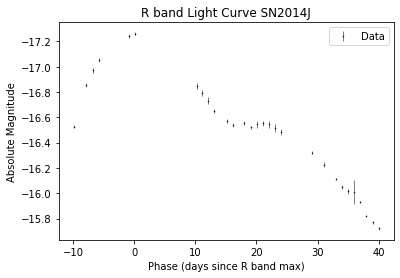



Observations, and Gaussian Process fit.


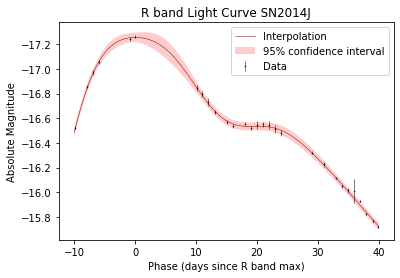



Observations and fit with no confidence interval.


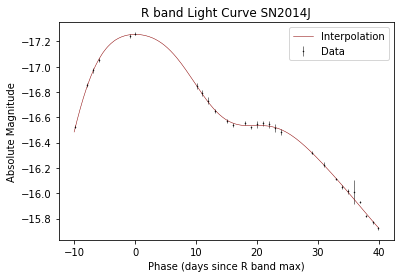

In [8]:
print('Just observations.')
SN.plot_curve(interpolated=False) # plot only the data points

print('\n\nObservations, and Gaussian Process fit.')
SN.plot_curve(interpolated=True)  # plot data points, interpolation and confidence interval

print('\n\nObservations and fit with no confidence interval.')
SN.plot_curve(interpolated=True, uncertainty=False) # plot data points and interpolation only

###### Other attributes
 - The `sources` attribute gives the sources of data in the desired band, and the number of observations each have.

In [9]:
SN.sources

2014MNRAS.443.2887F,Sternberg Astronomical Institute Supernova Light Curve Catalogue    29
Name: source, dtype: int64

 - The `dist_mod` attribute gives the distance modulus of the SN, calculatied using the luminosity distance.

In [10]:
SN.dist_mod

27.384158142561304

  - The `redshift` attribute gives the redshift of the supernova. In the case where there are more than one values given, the value with the most sources associated with it is given.

In [11]:
SN.redshift

0.000677

 - The `kernel` attribute is the posterier kernel of the Gaussian Process fit (ie, the optimised kernel.) This was made an attribute in order to assess the interpolation by eye, as seeing the optimised length scales was useful. 

In [12]:
SN.kernel

7.07**2 + RBF(length_scale=9.45) + WhiteKernel(noise_level=0.000174)

###### Machine Learning Inputs

These are contained in the attributes `input` and `input_err`.

In [13]:
print(SN.input,SN.input_err)

[-16.48415179 -16.53306481 -16.58034286 -16.62653093 -16.66988466
 -16.71207504 -16.75252038 -16.7906075  -16.82751434 -16.86205827
 -16.89484557 -16.92646176 -16.9552056  -16.98283332 -17.00878688
 -17.03259273 -17.05534989 -17.07605991 -17.09531982 -17.11361297
 -17.12964366 -17.14483448 -17.15876551 -17.17115056 -17.18279614
 -17.19302987 -17.20230336 -17.21093669 -17.21812735 -17.22480011
 -17.23069602 -17.23566445 -17.24019327 -17.24389113 -17.24702826
 -17.24979155 -17.25170672 -17.25330987 -17.25444498 -17.25499574
 -17.25526067 -17.25496655 -17.25426193 -17.25328364 -17.25162023
 -17.24967695 -17.24731386 -17.24437024 -17.24112942 -17.23728028
 -17.23295046 -17.2283002  -17.22280506 -17.21695446 -17.21057068
 -17.20344338 -17.19593733 -17.18765982 -17.17878792 -17.16951975
 -17.15924554 -17.14856799 -17.13728542 -17.1252061  -17.1127341
 -17.09948809 -17.0856887  -17.07152037 -17.05649196 -17.04115112
 -17.02534165 -17.0089834  -16.99237274 -16.97530127 -16.95795805
 -16.940433

These are simply the interpolated light curve, and the uncertainty associated with the fit respectively:

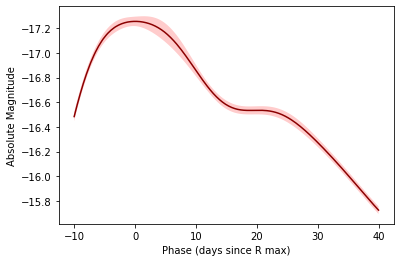

In [14]:
x = np.linspace(SN.t_min, SN.t_max, SN.num_steps)
plt.plot(x, SN.input, c='darkred')
plt.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([SN.input - 1.9600 * SN.input_err, 
                        (SN.input + 1.9600 * SN.input_err)[::-1]]),
        alpha=.2, fc='r', ec='None')
plt.gca().invert_yaxis()
plt.xlabel(f'Phase (days since {SN.band} max)')
plt.ylabel('Absolute Magnitude')
plt.show()

Note that these values are not normalised to valuse between 0 and 1, as should be when training machine learning algortihms. This was done manually.

#### SN 2012fr

As mentioned earlier, sometimes there can be observations by multiple sources in the region of interest. This will affect the shape of the interpolated light curve, which will in turn affect the training process of different machine learning algorithms. Take SN2012fr for example. Here, the data is loaded from the OACAPI, and the `plot_curve` method is called. Note that the `check_source` attribute has been set to `False`, for demonstration purposes.

Loading data for SN2012fr from API.

Data loaded.

Loading redshift.
z = 0.0054

Loading the claimed type.
Claimed type: Ia

Calculating distance modulus from luminosity distance.
M-m = 31.901056208558032

Cleaning data.

Deleting nans.

Locating measurements in R band.

Converting time to float.

Converting from -10 to 40 days since R band max.

checking for large gaps between observations.

Converting to absolute magnitude.

Interpolating.



C:\Users\Ciaran\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Now shifting time of max brightness to the time at which interpolation is brightest.

Loading Sources.

Finished in 16.53 seconds.


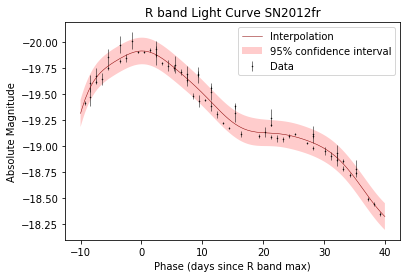

2017MNRAS.472.3437G    41
2014AJ....148....1Z    22
Name: source, dtype: int64

In [15]:
SN2012fr_multipleSources = OpenSN('SN2012fr', 'R', check_source=False, verbose=True)
SN2012fr_multipleSources.plot_curve(interpolated=True)
SN2012fr_multipleSources.sources

As can be seen, there are two distinct groups of observations: one with a smaller, regular cadence, and is slightly dimmer, and one with a larger, irregular cadence, with larger uncertainties, and is slightly brighter. This has affected the overall shape of the interpolated fit. Although the shape is not drastically different, this may be a big issue for other SNe.

Now we will set `check_source=True`, and `verbose=False`.

C:\Users\Ciaran\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


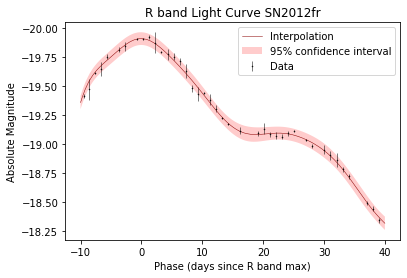

2017MNRAS.472.3437G    41
Name: source, dtype: int64

In [16]:
SN2012fr_oneSource = OpenSN('SN2012fr', 'R', check_source=True)
SN2012fr_oneSource.plot_curve(interpolated=True)
SN2012fr_oneSource.sources

From this plot, it can be seen that only the data points from '2017MNRAS.472.3437G' have been included, since that is the source with the most observations. As a result, the Gaussian Process fit is a better representation of the light curve.

#### SN 1987A
Next we will look at SN 1987A. There are no uncertainties associated with this data, so when the data is loaded with all the initial parameters, the class should return False for the light curve.

In [17]:
SN1987A = OpenSN('SN1987A','R',verbose=True)

Loading data for SN1987A from API.

Data loaded.

Loading redshift.
z = 1.16e-05

Loading the claimed type.
Claimed type: II Pec,II,II P,CC

Calculating distance modulus from luminosity distance.
M-m = 18.16734227789793

Cleaning data.

Deleting nans.

Locating measurements in R band.

Converting time to float.

Light curve did not load, returning False.

Loading Sources.

Finished in 2.75 seconds.


In [18]:
SN1987A.light_curve

False

In [19]:
SN1987A.plot_curve()

False

`OpenSN` has returned `False` here when loading the light curve, and when trying to plot the curve. Since the raw data has been loaded, which we know from lines 1 and 2 of the cell [above](#SN-1987A), we can see what the `raw_data` attribute looks like.

In [20]:
SN1987A.raw_data.head(50)

,event,time,magnitude,e_magnitude,band,source
0,SN1987A,46849.44,6.36,NaN,V,"1987IAUC.4495....1M,Sternberg Astronomical Ins..."
1,SN1987A,46849.62,6.11,NaN,V,"1987IAUC.4495....1M,Sternberg Astronomical Ins..."
2,SN1987A,46850.45,4.89,NaN,B,"1987IAUC.4313....1M,Sternberg Astronomical Ins..."
3,SN1987A,46850.45,4.06,NaN,U,"1987IAUC.4313....1M,Sternberg Astronomical Ins..."
4,SN1987A,46850.45,4.81,NaN,V,"1987IAUC.4313....1M,Sternberg Astronomical Ins..."
5,SN1987A,46850.80,4.74,NaN,B,"1987IAUC.4320....1F,Sternberg Astronomical Ins..."
6,SN1987A,46850.80,4.29,NaN,I,"1987IAUC.4320....1F,Sternberg Astronomical Ins..."
7,SN1987A,46850.80,4.37,NaN,R,"1987IAUC.4320....1F,Sternberg Astronomical Ins..."
8,SN1987A,46850.80,3.95,NaN,U,"1987IAUC.4320....1F,Sternberg Astronomical Ins..."
9,SN1987A,46850.80,4.63,NaN,V,"1987IAUC.4320....1F,Sternberg Astronomical Ins..."


It can be seen that each entry of the `e_magnitude` column is a `NaN`, so by default, `OpenSN` will delete each row with a `NaN` in it, thus deleting the entire dataframe. To avoid this, set `exclude_no_errors=False`. 

Also, in the following example, `day_range` will be set to `False` in order to demonstrate that the light curves may be observed in MJD, and, by setting `check_source=False` the entire light curve in the R band may be observed. This may take a while, since the light curve is taken over almost 200 days.

Loading data for SN1987A from API.

Data loaded.

Loading redshift.
z = 1.16e-05

Loading the claimed type.
Claimed type: II Pec,II,II P,CC

Calculating distance modulus from luminosity distance.
M-m = 18.16734227789793

Cleaning data.

Deleting nans.

Locating measurements in R band.

Converting time to float.

Converting to absolute magnitude.

Interpolating.



C:\Users\Ciaran\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Ciaran\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 15. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Ciaran\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Loading Sources.

Finished in 68.78 seconds.


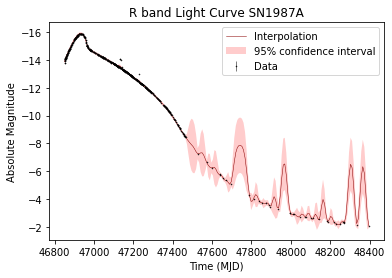

In [21]:
SN1987A_no_errors = OpenSN('SN1987A', 'R', check_source=False,day_range=False, exclude_no_errors=False, verbose=True)
SN1987A_no_errors.plot_curve(interpolated=True)

Also seen here is what happens when there are sparse gaps between observations - the Gaussian Process interpolation fails.

#### PTF12hsx
This is another example where the photometry data is not good and the Guassian Process interpolation fails to accurately represent the light curve.

C:\Users\Ciaran\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


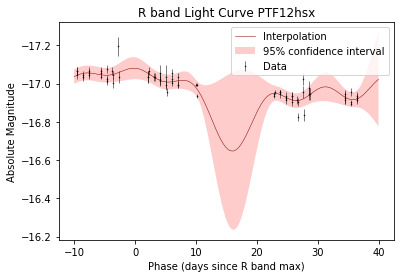

In [22]:
PTF12hsx = OpenSN('PTF12hsx', 'R')
PTF12hsx.plot_curve(interpolated=True)

## Data Acquisition with `OpenSN`

As mentioned at the beginning, `OpenSN` was designed in order to obtain light curve data from the OACAPI. The following section describes how this was done for the type Ia SNe.

Firstly, create lists where desired data will be stored.

In [23]:
Ias_X = []          # interpolated data
Ias_X_err = []      # interpolated data uncertainty
Ias_X_norm = []     # normalised interpolated data
Ias_X_norm_err = [] # normalised interpolated data uncertainty
Ias_y = []          # type, output for ML
Ias_names = []      # list to store the names

band = 'R'          # band where data will be retrieved

Next, load SNe from the OACAPI whose claimed type is Ia (`catalog/claimedtype?claimedtype=ia`). 

(Due to the abundance of type Ias in the OSC, especially compared to type IIs and Ib/cs, only those whose name started with `SN2...` were examined. This was to reduce the searching time.)

In [ ]:
Ia_set = pd.read_csv('https://api.astrocats.space/catalog/claimedtype?claimedtype=ia&format=csv')[10:] #load csv of all Ias
Ia_target = Ia_set['event'][Ia_set['event'].str.contains('SN2')][190:] # to reduce searching time

In [ ]:
Ia_target.head(10)

The following cell outlines the data acquistion process. **It is not recommended that this cell is run**, as it took more than 3 hours to execute. Its purpose is to demonstrate what the data acquistion process consisted of. 

In [ ]:
t0 = time.time() # get current time, just to inspect performance
i=1 # a counter, to keep track of how many has been searched

for name in Ia_target:
    #load curve from API
    SN = OpenSN(name, band)
    try:
        # if the SN has passed all conditions (does the API exist, is there 
        # enough points in the desired band, are the points close to the
        # upper and lower bounds of the day range)
        # If so, SN.input will exist, and SN.input.any() will be True,
        # and no error will be raised, therefore the try statement will
        # be executed
        SN.input.any()
        
        # store the:
        Ias_X.append(SN.input)                             # interpolated data
        Ias_X_err.append(SN.input_err)                     # interpolated data uncertainty
        Ias_X_norm.append(SN.input/SN.input.min())         # normalised light curve
        Ias_X_norm_err.append(SN.input_err/SN.input.min()) # normalised light curve uncertainty
        Ias_y.append(SN.type)                              # type 
        Ias_names.append(SN.name)                          # name
        
        print(i,'. Found a good one! It\'s '+ name)

    except:
        print(i,'. Nothing... (', SN.name, ')')
        pass
            
    i += 1
        
print('done in',time.time()-t0,'seconds') #to check how long data acquisition process took.

This process was repeated for type IIs, type Ibs and Ics, however each entry for these were examined, as there are not as many of these as there are type Ias.